August: Bathymetry for shelf and slope without canyon. Function moved to tools and implemented in final_bathymetry.

In [1]:
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_grid
import functions_realistic
import functions_plot

from netCDF4 import Dataset

In [2]:
x_final =  258
y_final =  int(0.75 * x_final)

extension_m = 90000#108061

smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504

search_x = [-1000000, -1450000, -1750000, -1400000]

In [3]:
# real world dimensions
x_wall, y_wall, fluid_depth = functions_idealized.base_measurements()

# stere corners
lon_s_corners_can, lat_s_corners_can = functions_grid.match_domain(x_wall, y_wall, search_x)

# extension
x_wall_ext = x_wall + extension_m

# stere corners + extension
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

# geog corners
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

# southern points
lonW, latW, lonE, latE = functions_grid.get_southern_points(lon_g_corners, lat_g_corners)

# geog grid
lon_g_grid, lat_g_grid = functions_grid.create_grid(x_final, y_final, lonW, latW, lonE, latE)

# stere grid
lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

dx (distance between the corner southern point and its neighbour) [km]: 2.01291837407
dx2 (distance between the corner northern point and its neighbour) [km]: 2.00921328005


In [4]:
x_wall, y_wall = functions_idealized.extended_measurements(lon_s_grid, lat_s_grid)

x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(x_wall, y_wall)

In [5]:
xsize, ysize = x_final-2, y_final-2

x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall, y_wall)

z_ideal = functions_idealized.make_topo_smooth(y_edge, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast,
                                               cR, L, p, x, x_wall, w_break, w_mid, w_head,
                                               fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast)

In [6]:
def make_no_canyon(y, y_base, y_break, y_coast, x, x_wall, fluid_depth, z_bottom, z_break, z_coast):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_coast: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = functions_idealized.tanktopo(y, y_base, y_break, y_coast, fluid_depth, z_bottom, z_break, z_coast)
    
    #canyon_profile = canyontopo(y, y_base, y_paral, y_pointA, y_pointB, y_head, y_coast,
    #                            fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast)
  
    # Slope of the canyon as well as the shape
    #width_profile = widthprofile(y, y_base, y_head, y_coast, cR, L, p, w_break, w_mid, w_head)
  
    # Depth of the canyon (negative values set to zero)
    #canyondepth = slope_profile - canyon_profile
    canyondepth = slope_profile
  
    #canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        #topography[:,j] = (slope_profile - canyondepth * 
        #                   (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**50))
        topography[:,j] = slope_profile
    topo = -1* topography[0:-1, :]
    topo = np.fliplr(np.rot90(topo, 2))
   
    return topo

In [32]:
z_no_canyon = make_no_canyon(y_edge, y_base, y_break, y_coast, x, x_wall, fluid_depth, z_bottom, z_break, z_coast)
z_no_canyon.shape

(190, 255)

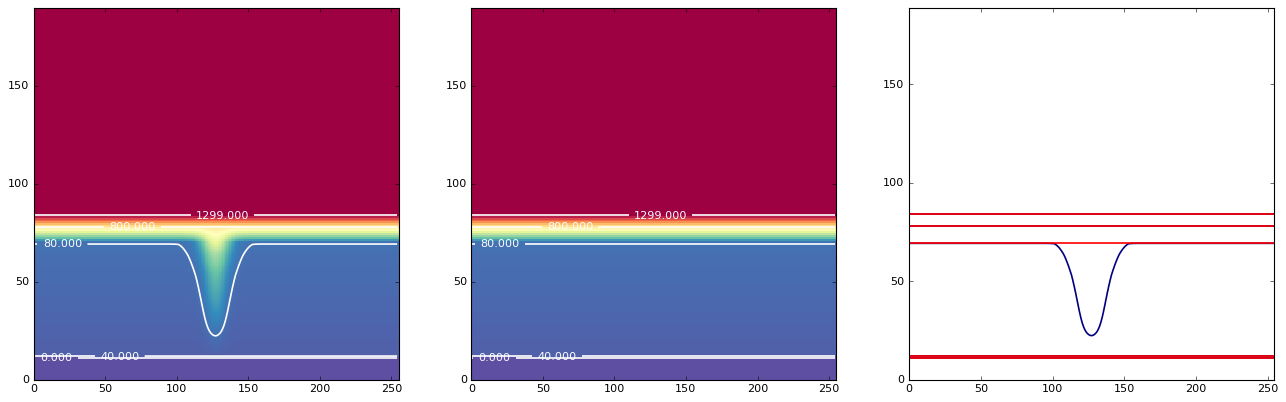

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
c1 = ax1.contour(z_ideal, levels = [0, 40, 80, 800, 1299], colors='w', linewidths=1.5)
ax1.pcolor(z_ideal, cmap=cm.Spectral_r)
c2 = ax2.contour(z_no_canyon, levels = [0, 40, 80, 800, 1299], colors='w', linewidths=1.5)
ax2.pcolor(z_no_canyon, cmap=cm.Spectral_r)
ax1.clabel(c1, inline=1, fontsize=10)
ax2.clabel(c2, inline=1, fontsize=10)
ax3.contour(z_ideal, levels = [0, 40, 80, 800, 1299], colors='Navy', linewidths=1.5)
ax3.contour(z_no_canyon, levels = [0, 40, 80, 800, 1299], colors='r', linewidths=1.5)


(0, 100)

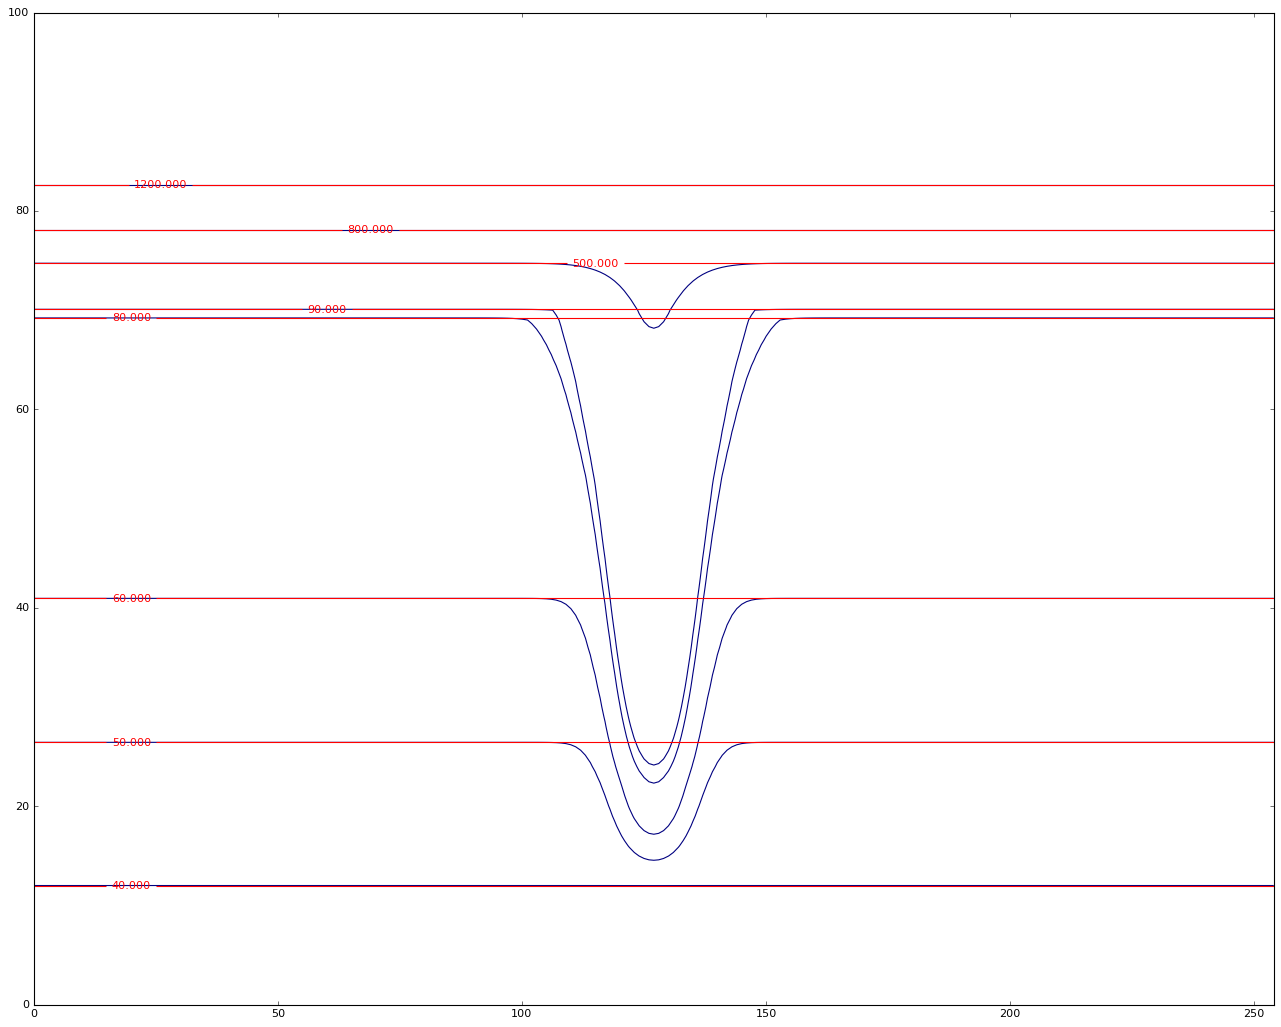

In [34]:
levels = [40, 50, 60, 80, 90, 500, 800, 1200]
fig, ax = plt.subplots(1, 1, figsize=(20,16))
c1=ax.contour(z_ideal, levels = levels, colors='Navy', linewidths=1)
c2=ax.contour(z_no_canyon, levels = levels, colors='r', linewidths=1)
ax.clabel(c2, inline=1, fontsize=10)
ax.set_ylim([0, 100])